# Explore here

In [1]:
import pandas as pd
import numpy as np, random
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import os
import dotenv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
random.seed(42)

Dado que tenemos una Nvidia 980ti buscaremos las versiones compatibles entre si:
Nvidia 980ti
Cuda 11.8
cuDNN 8.9.7.29
tensorflow-2.14.0
Python3.10
numpy==1.26.4
pandas==2.0
Este sera nuestro setup para Redes neuronales.

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
#Dado que nos sale la importacion keras en cursiva nos aseguramos de que funcione con este pequeño test.
model = Sequential([
    Input(shape=(3,)), # Define la forma de entrada aquí
    Dense(2, activation='relu'),
    Dense(1)
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 8         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 11 (44.00 Byte)
Trainable params: 11 (44.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


9 imágenes aleatorias de gatos:


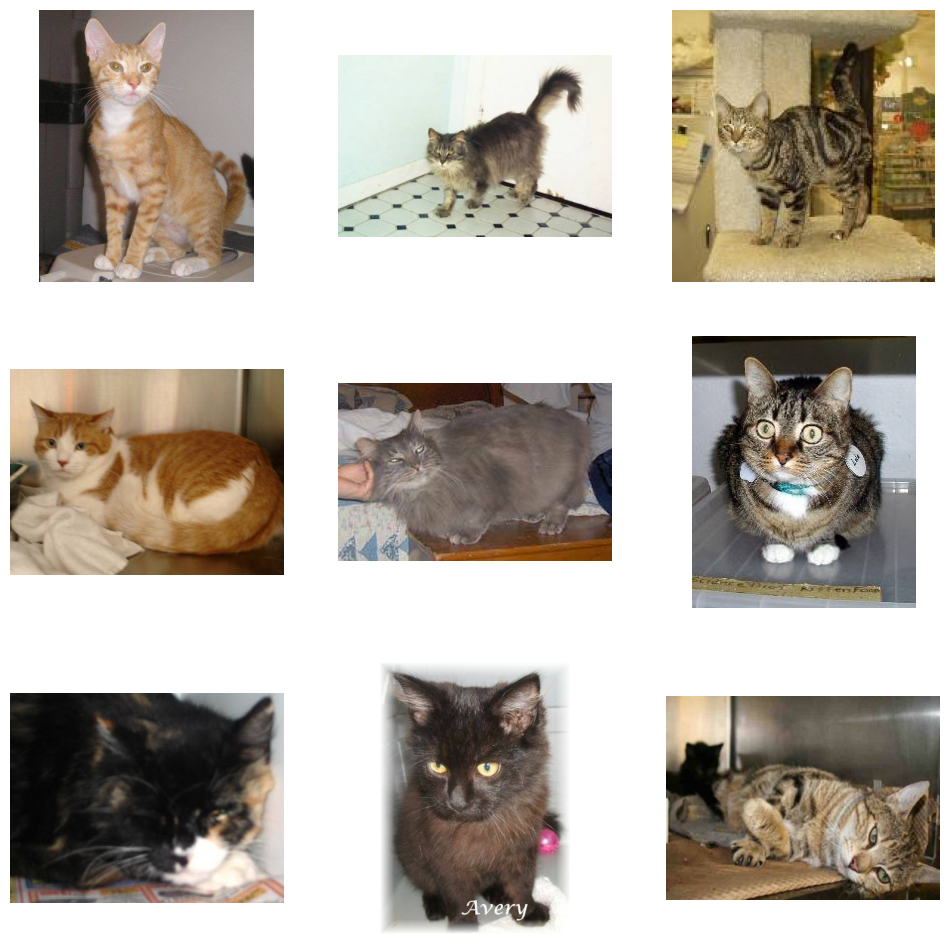

9 imágenes aleatorias de perros:


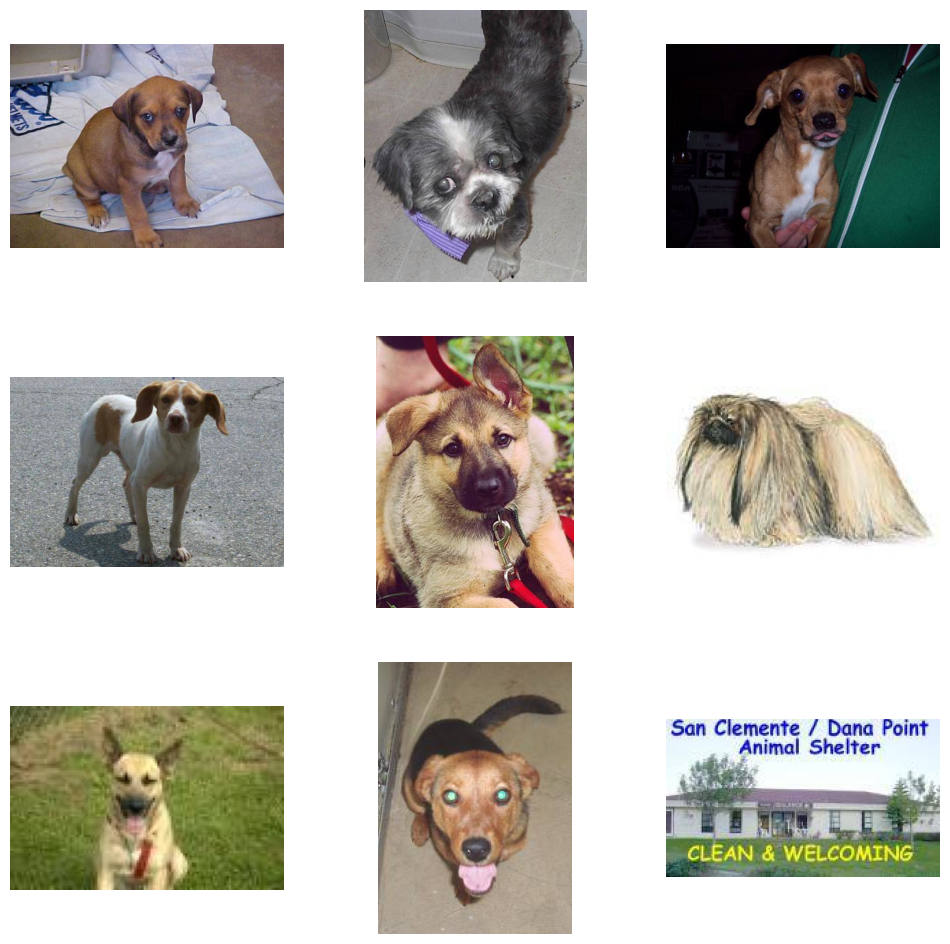

In [3]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
random.seed(42)


path = "C:/Users/Josue/4GA.DataScience/pictures/train"


# Creamos una lista vacia para almacenar las imagenes , 9 random pictures de cada tipo de la carpeta train.
gatos = []
perros = []

for filename in os.listdir(path):
    if filename.startswith("cat"):
        gatos.append(os.path.join(path, filename))
    elif filename.startswith("dog"):
        perros.append(os.path.join(path, filename))


gatos_random = random.sample(gatos, 9)


print("9 imágenes aleatorias de gatos:")
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(gatos_random):
    plt.subplot(3, 3, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
plt.show()


perros_random = random.sample(perros, 9)


print("9 imágenes aleatorias de perros:")
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(perros_random):
    plt.subplot(3, 3, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [4]:

#from keras.preprocessing.image import ImageDataGenerator
#Para que funcione esta modulo de la libreria necesitamos instalar 2 dependencias:
#pip install numpy, pip install Pillow
#En la llamada a la libreria y su modulo es para otra version de python diferente a 3.10.
#En nuestro caso utilizaremos este:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Definimos el train/test y varios parametros. Al ser un preprocesado, escogemos la conversion de pixeles y dimensiones de las imagenes.
#Nos aseguramos que la carpeta pesada esta ignorada a la hora de commitear a github, donde se aloja las imagenes y el resultado del modelo.
#Escojo dimensiones 100x100 por temas de tiempo de proceso
train_dir = "C:/Users/Josue/4GA.DataScience/pictures/train"
test_dir = "C:/Users/Josue/4GA.DataScience/pictures/test"
image_size = (100, 100)

trainpre = ImageDataGenerator()
testpre = ImageDataGenerator()

# Pasamos la feature a cada bloque de datos del split train/test
train = trainpre.flow_from_directory(
    train_dir,
    target_size=image_size,
    classes=["dog", "cat"]
)

# Test Data Generation
test = testpre.flow_from_directory(
    test_dir, # Corrected path
    target_size=image_size,
    classes=["dog", "cat"] # Corrected classes
)
print(train_dir,'\n',test_dir)

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
C:/Users/Josue/4GA.DataScience/pictures/train 
 C:/Users/Josue/4GA.DataScience/pictures/test


No me detecta las imagenes, dado que la funcion flow_from_directory espera subdirectorios que separen las imagenes de cats y dogs.
Es la practica standard cuando se usa la feature ImageDataGenerator.
Tambien influye la tipologia de los nombres, el punto entre la clase de imagen y la enumeracion hace que no funcione bien la funcion.
Utilizaremos otro metodo a  traves de un dataframe de etiquetado.
Gracias a la etiquetacion de las imagenes de train tendremos una classificacion categorica de las imagenes en el preprocesado
que nos servira de base para "enseñar a la red neuronal" una aprendizaje de reconocimiento de imagenes.
si nos fijamos en el csv de test_labels o sample submission , la id coincide con el numero de imagen  que a su vez es el numero de la imagen,
ademas la segunda columna 'label' al tener todas las imagenes 0, nos indica que todas las imagenes tienen la misma clase,
diferente a la de la carpeta train. Ese label es la categoria que la red neuronal tendra que predecir.

In [ ]:
import os
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import numpy as np

def rename_files(directory):
    for filename in os.listdir(directory):
        if filename.startswith("cat.") or filename.startswith("dog."):
            new_filename = filename.replace(".", "")
            old_filepath = os.path.join(directory, filename)
            new_filepath = os.path.join(directory, new_filename)
            os.rename(old_filepath, new_filepath)

def create_dataframe_train(directory):
    filepaths = []
    labels = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if filename.startswith("cat"):
            label = 1
        elif filename.startswith("dog"):
            label = 2
        else:
            continue
        filepaths.append(filepath)
        labels.append(label)
    return pd.DataFrame({"filepaths": filepaths, "labels": labels})

def create_dataframe_test_for_predictions(directory):
    filepaths = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if filename.endswith(".jpg"):
            filepaths.append(filepath)
    labels = [0] * len(filepaths)
    return pd.DataFrame({"filepaths": filepaths, "labels": labels})


train_dir = "C:/Users/Josue/4GA.DataScience/pictures/train"
test_dir = "C:/Users/Josue/4GA.DataScience/pictures/test"
image_size = (200, 200) 

rename_files(train_dir)

train_df = create_dataframe_train(train_dir)
test_df = create_dataframe_test_for_predictions(test_dir)

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=image_size,
    class_mode="raw",
    batch_size=32
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=image_size,
    class_mode="raw",
    batch_size=32,
    shuffle=False
)

# Modelo
base_model = EfficientNetB0(input_shape=(200, 200, 3), include_top=False, weights='imagenet') 
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validación cruzada (2 folds)
kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, val_index in kf.split(train_df):
    print(f"Fold {fold_no}")
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]
    train_generator_fold = train_datagen.flow_from_dataframe(
        dataframe=train_fold,
        x_col="filepaths",
        y_col="labels",
        target_size=image_size,
        class_mode="raw",
        batch_size=32
    )
    val_generator_fold = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        dataframe=val_fold,
        x_col="filepaths",
        y_col="labels",
        target_size=image_size,
        class_mode="raw",
        batch_size=32
    )
    history = model.fit(
        train_generator_fold,
        epochs=4, #
        validation_data=val_generator_fold,
        callbacks=[early_stopping]
    )
    scores = model.evaluate(val_generator_fold, verbose=0)
    print(f"Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no += 1

print("Average scores for all folds:")
print(f"> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})")
print(f"> Loss: {np.mean(loss_per_fold)}")

# Predicciones y columna descriptiva
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

def map_label_to_description(label):
    if label == 0:
        return "unknown"
    elif label == 1:
        return "cat"
    elif label == 2:
        return "dog"
    else:
        return "unknown"

predicted_descriptions = [map_label_to_description(label) for label in predicted_classes]

predictions_df = pd.DataFrame({
    "predicted_label": predicted_classes,
    "predicted_description": predicted_descriptions
})

print(predictions_df)




Found 25000 validated image filenames.
Found 12500 validated image filenames.
Fold 1
Found 12500 validated image filenames.
Found 12500 validated image filenames.
Epoch 1/4
391/391 [==============================] - 390s 989ms/step - loss: 0.7128 - accuracy: 0.5022 - val_loss: 0.7008 - val_accuracy: 0.4954
Epoch 2/4
391/391 [==============================] - 388s 994ms/step - loss: 0.7006 - accuracy: 0.4951 - val_loss: 0.6946 - val_accuracy: 0.5046
Epoch 3/4
391/391 [==============================] - 381s 974ms/step - loss: 0.6982 - accuracy: 0.4969 - val_loss: 0.6961 - val_accuracy: 0.4954
Epoch 4/4
391/391 [==============================] - 378s 969ms/step - loss: 0.6960 - accuracy: 0.5003 - val_loss: 0.6982 - val_accuracy: 0.4954
Score for fold 1: loss of 0.6981921195983887; accuracy of 49.535998702049255%
Fold 2
Found 12500 validated image filenames.
Found 12500 validated image filenames.
Epoch 1/4
391/391 [==============================] - 379s 969ms/step - loss: 0.6958 - accuracy

#Entrenamos el modelo, visto los numeros de imagen la proporcion de train test es 2/3 y 1/3 respectivamente.


Puede mejorar el modelo, incrementando el learning rate y ajustando otros parametros, haciendo folds para validacion cruzada, reservando muestras del conjunto de train, en este caso estoy utilizando el mismo conjunto de test como
conjunto de validacion, incluso utilizar otro modelo que no sea EficientNetB0.
El warning aparece porque el formato de salida del modelo es antiguo, se puede modificar a .keras en el apartado de callbacks.
Primer intento devolviendo clase 0 , es decir que no ha predicho ninguna clase en el conjunto de prediccion y me ha devuelto 0 como estaba antes en labels, por lo tanto hay algun problema a la hora de asignar las clases.


In [13]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np


model = load_model("C:/Users/Josue/4GA.DataScience/pictures/models/efficientnetb0_best_model.h5")
img_path = 'C:/Users/Josue/4GA.DataScience/pictures/gato.jpg '
img = image.load_img(img_path, target_size=(100, 100))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

def map_label_to_description(label):
    if label == 0:
        return "unknown"
    elif label == 1:
        return "cat"
    elif label == 2:
        return "dog"
    else:
        return "unknown"

predicted_description = map_label_to_description(predicted_class)

print(f"Clase predicha: {predicted_class}")
print(f"Descripción: {predicted_description}")

1/1 [==============================] - 1s 730ms/step
Clase predicha: 1
Descripción: cat
